In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import argparse
import gymnasium as gym
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import pandas as pd



gamma=0.99

log_interval=10


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(7, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

#for trained testing: optimizer is loaded from checkpoint
model_trained = Policy()


# for untrained testing
model_untrained = Policy()
optimizer_untrained = optim.Adam(model_untrained.parameters(), lr=1e-2)


eps = np.finfo(np.float32).eps.item()


#####

env = gym.make("two-step-task-original-v0", render_mode='human')

In [ ]:
# Load the checkpoint from Google Drive
path = "/content/drive/MyDrive/Models/folder_name/"
#file_name = "best_checkpoint_805_eps_178_score_RNN_hidden_128_layres1_16-10-2024_18:21:43.pth"
#file_name2 = "best_checkpoint_1885_eps_138_score_RNN_hidden_128_layres1_17-10-2024_22:12:05.pth"
file_name_trained="best_checkpoint_atThreshold346.pth"
checkpoint_tarined = torch.load(f"{path}{file_name_trained}", weights_only=False)

# Load the model and optimizer state
optimizer = optim.Adam(model_trained.parameters())  # Recreate the optimizer with the same settings as before
model_trained.load_state_dict(checkpoint_tarined['model_state_dict'])
optimizer.load_state_dict(checkpoint_tarined['optimizer_state_dict'])
model_trained.train()



Policy(
  (affine1): Linear(in_features=7, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (affine2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# Function to test the trained policy
def test_policy(policy, env, num_episodes=100, render=False, nnType = 'Trained',action_given=0):
    # Put the model in evaluation mode
    policy.eval()

    # Disable gradient calculations during inference
    with torch.no_grad():
        running_reward = 10
        # Step 1: Create an empty DataFrame with required columns, for plotting later
        df = pd.DataFrame(columns=['episode', 'trial_num', 'actionInS1', 'stateInS1',
                               'common', 'actionIS2', 'reward', 'stateInS2', 'score',
                               'p_win_state1_action1','p_win_state1_action2',
                               'p_win_state2_action1', 'p_win_state2_action2','stake'])
        for i in range(num_episodes):
            state = env.reset()[0]
            done = False
            score = 0
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            for t in range(1, 10000):
                if render:
                  env.render()

                # Convert state to tensor and send to device
                state_tensor = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)

                # Get action probabilities from the policy
                action_probs = policy(state_tensor)

                # Sample action
                action_dist = Categorical(action_probs)
                action = action_dist.sample()
               #if NN is untrained make it Biased to the opposite action (in this case 1)
                if nnType== 'Trained':
                  action_to_use= action.item()
                else:
                  action_to_use= action_given
                if t % 2 != 0:
                    df.loc[len(df), ['actionInS1','stateInS1']] = [action_to_use, state]
                else:
                    df.loc[len(df)-1, [ 'stateInS2']] = [state]

                # Take action in the environment
                next_state, reward, done, _, info = env.step(action_to_use)
                score += reward
                if t % 2 ==0:
                    matrix=info["winning_matrix"]
                    matrix= matrix.tolist()
                    df.loc[len(df)-1, ['actionIS2', 'reward', 'score', 'p_win_state1_action1',
                                   'p_win_state1_action2', 'p_win_state2_action1', 'p_win_state2_action2']] = [action_to_use, reward, score,
                                                                                                               matrix[0][0], matrix[0][1],
                                                                                                               matrix[1][0], matrix[1][1]]
                else:
                    df.loc[len(df)-1, ['episode', 'trial_num', 'common', 'stake']] = [i, info["number of trials"], info["common"], info["stake"]]


                # Update state
                state = next_state
                if done:
                    break

            print(f"Episode {i+1} finished with total reward: {score}")
            running_reward = 0.05 * score + (1 - 0.05) * running_reward  # Update running reward
            # Save to a CSV file
            df.to_csv(f'output_normal_2_test{nnType}_BiasTo{action_given}.csv', index=False)
            !mv   /content/output*.csv /content/drive/MyDrive/Models/folder_name/


    env.close()
    return  df


In [ ]:
# Test the trained policy
df_trained = test_policy(model_trained, env, num_episodes=100, render=True, nnType = 'Trained',action_given=1)

# Test the untrained policy
df_untrained = test_policy(model_untrained, env, num_episodes=100, render=True, nnType = 'Untrained',action_given=0)

Streaming output truncated to the last 5000 lines.
obs is [  0   1   0   3   4   1 353]
R_1   R_2 
      
  Age   

action 0
obs is [  1   0   0   2   1   1 354]
Blu   Gre 
      
  Age   

action 0
obs is [  0   0   1   5   6   1 354]
P_1   P_2 
      
  Age   

action 0
obs is [  1   0   0   2   1   5 354]
Blu   Gre 
      
  Age   

action 0
obs is [  0   1   0   4   3   5 354]
R_2   R_1 
      
  Age   

action 0
obs is [  1   0   0   1   2   1 354]
Gre   Blu 
      
  Age   

action 0
obs is [  0   0   1   6   5   1 354]
P_2   P_1 
      
  Age   

action 0
obs is [  1   0   0   2   1   1 355]
Blu   Gre 
      
  Age   

action 0
obs is [  0   0   1   6   5   1 355]
P_2   P_1 
      
  Age   

action 0
obs is [  1   0   0   1   2   5 356]
Gre   Blu 
      
  Age   

action 0
obs is [  0   1   0   3   4   5 356]
R_1   R_2 
      
  Age   

action 0
obs is [  1   0   0   2   1   5 361]
Blu   Gre 
      
  Age   

action 0
obs is [  0   0   1   5   6   5 361]
P_1   P_2 
      
  Age 

In [ ]:
import pandas as pd

# Define the file path
file_trained= '/content/drive/My Drive/Models/folder/output_normal_testTrained.csv'
file_untrained= '/content/drive/My Drive/Models/folder/output_normal_testBiased_To0.csv'

# Load the CSV into a DataFrame
df_trained = pd.read_csv(file_trained)

df_untrained = pd.read_csv(file_untrained)
# Display the first few rows of the DataFrame
print(df_trained.head(2))
print(df_untrained.head(2))



   episode  trial_num  actionInS1        stateInS1  common  actionIS2  reward  \
0        0          1           1  [1 0 0 1 2 1 0]    True          1       1   
1        0          2           1  [1 0 0 1 2 1 1]    True          1       1   

         stateInS2  score  p_win_state1_action1  p_win_state1_action2  \
0  [0 0 1 5 6 1 0]      1                 0.400                 0.600   
1  [0 0 1 6 5 1 1]      2                 0.386                 0.616   

   p_win_state2_action1  p_win_state2_action2  stake  
0                 0.250                 0.750      1  
1                 0.206                 0.727      1  
   episode  trial_num  actionInS1        stateInS1  common  actionIS2  reward  \
0        0          0           0  [1 0 0 2 1 1 0]    True          0       1   
1        0          1           0  [1 0 0 1 2 1 1]    True          1       0   

         stateInS2  score  p_win_state1_action1  p_win_state1_action2  \
0  [0 0 1 6 5 1 0]      1                 0.600       

In [ ]:
# Compare element-wise
comparison = df_trained['score'] > df_untrained['score']

# Count how many times df trained has better scores
dfTrained_better = comparison.sum()

# Count how many times df untrained has better scores
dfUntrained_better = (~comparison).sum()

print(f"df trained has better scores {dfTrained_better} times.")
print(f"df untrained has better scores {dfUntrained_better} times.")


df trained has better scores 10326 times.
df untrained has better scores 9674 times.


In [ ]:
# Calculate the sum of scores
df_Trained_total = df_trained['score'].sum()
df_Unrained_total = df_untrained['score'].sum()

print(f"df trained total score: {df_Trained_total}")
print(f"df untrained total score: {df_Unrained_total}")

# Determine the better DataFrame
if df_Trained_total > df_Unrained_total:
    print("df trained has better overall scores.")
else:
    print("df untrained has better overall scores.")


df trained total score: 3094181
df untrained total score: 3001633
df trained has better overall scores.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Function to calculate how many stage 1 actions were repeated from the previous trial and in the next trial
def calculate_repeated_action(data: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the data to avoid modifying the original DataFrame
    tmp_df = data.copy()

    # Convert 'reward' column to boolean values (True/False)
    tmp_df['reward'] = tmp_df['reward'].astype(bool)

    # Check if the action taken in Stage 1 (actionInS1) was the same as in the previous trial
    tmp_df['repeated_stepOneAction'] = tmp_df['actionInS1'].shift(1) == tmp_df['actionInS1']

    # Check if the action taken in Stage 1 (actionInS1) was the same as in the next trial
    tmp_df['repeated_stepOneAction_next'] = tmp_df['repeated_stepOneAction'].shift(-1)

    # Return the modified DataFrame, excluding the last row (since there's no next trial for it)
    return tmp_df.iloc[:-1]

# Function to calculate the probability of staying with the same action based on the reward and stimulus condition
def calculate_stay_probability(data: pd.DataFrame) -> pd.DataFrame:
    # First, calculate the repeated actions using the helper function
    tmp_df = calculate_repeated_action(data.copy())

    # Group data by reward and common stimulus condition and calculate the mean of 'repeated_stepOneAction_next'
    results = tmp_df.groupby(['reward', 'common'])['repeated_stepOneAction_next'].mean().reset_index()

    # Rename columns for better readability
    results.rename(columns={'repeated_stepOneAction_next': 'Stay Probability', 'reward': 'Rewarded', 'common': 'Common'}, inplace=True)

    # Create a new column 'Condition' based on the reward and common columns
    results['Condition'] = results.apply(lambda row: f"{'rewarded' if row['Rewarded'] else 'unrewarded'}_{'common' if row['Common'] else 'rare'}", axis=1)

    # Convert 'Stay Probability' to numeric and fill any NaN values with 0, rounding to 3 decimal places
    results['Stay Probability'] = pd.to_numeric(results['Stay Probability'], errors='coerce').fillna(0).round(3)

    # Return the results DataFrame
    return results

# Function to calculate the running stay probabilities over trials for different conditions
def calculate_running_stay_probabilities(data: pd.DataFrame) -> pd.DataFrame:
    # Calculate repeated actions using the helper function
    task_df = calculate_repeated_action(data.copy())

    # Define the conditions we're interested in
    conditions = ['common_rewarded', 'common_unrewarded', 'rare_rewarded', 'rare_unrewarded']

    # Initialize dictionaries to keep track of counts for each condition
    stay_counts = {cond: 0 for cond in conditions}
    total_counts = {cond: 0 for cond in conditions}

    # Create a new column to store stay decisions (True or False)
    task_df['stay_decision'] = task_df['repeated_stepOneAction_next']

    # Loop through each row to update stay counts for each condition
    for i, row in task_df.iterrows():
        # Determine the current condition (common/uncommon, rewarded/unrewarded)
        condition = f"{'common_' if row['common'] else 'rare_'}{'rewarded' if row['reward'] else 'unrewarded'}"

        # If the agent stayed with the same action, increment the stay count for that condition
        if row['stay_decision']:
            stay_counts[condition] += 1
        total_counts[condition] += 1

        # Calculate the stay probability for each condition at this point in the trial
        for cond in conditions:
            if total_counts[cond] > 0:  # Avoid division by zero
                task_df.at[i, f"{cond}_prob"] = stay_counts[cond] / total_counts[cond]

    # Rename columns for clarity
    return task_df.rename(columns={'common_rewarded_prob': 'rewarded_common', 'common_unrewarded_prob': 'unrewarded_common', 'rare_rewarded_prob': 'rewarded_rare', 'rare_unrewarded_prob': 'unrewarded_rare'})

# Function to calculate the moving average of the cumulative reward over a rolling window
def calculate_average_cumulative_reward_moving_average(data: pd.DataFrame, window_size=10) -> pd.DataFrame:
    # Create a copy of the data to avoid modifying the original
    tmp_df = data.copy()

    # Calculate the moving average of the reward using the rolling window
    tmp_df['avg_cumulative_reward'] = tmp_df['reward'].rolling(window=window_size, min_periods=1).mean()

    # Print the first few rows to see the result
    print(tmp_df.head(6))

    # Return the modified DataFrame with the moving average
    return tmp_df

# Function to plot the results of the calculations, including stay probabilities, running stay probabilities, and cumulative reward
def plot_combined_single(data, label='', title='', window_size=50):
    # Set the plot style to a clean white grid
    sns.set_style("whitegrid")

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    # Plot Stay Probabilities (rewarded vs unrewarded, common vs rare)
    stay_prob_df = calculate_stay_probability(data)
    stay_prob_df['Rewarded'] = stay_prob_df['Rewarded'].map({True: 'Rewarded', False: 'Unrewarded'})
    stay_prob_df['Common'] = stay_prob_df['Common'].map({True: 'Common', False: 'Rare'})
    sns.barplot(x='Rewarded', y='Stay Probability', hue='Common', data=stay_prob_df, ax=axes[0], order=['Rewarded', 'Unrewarded'], hue_order=['Common', 'Rare'])
    axes[0].set_title(f'Stay Probabilities - {label}')
    axes[0].set_ylim(0, 1)  # Set y-axis limits to 0 and 1
    axes[0].legend(loc='upper right')

    # Plot Running Stay Probabilities
    running_stay_df = calculate_running_stay_probabilities(data)
    for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']:
        running_stay_df[f'{cond}_ma'] = running_stay_df[f'{cond}'].rolling(window=window_size, min_periods=1).mean()
    running_stay_df.plot(x='trial_num', y=[f'{cond}_ma' for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']],
                         ax=axes[1], title=f'Running Stay Probabilities - {label}')

    # Plot Average Cumulative Reward
    avg_cum_reward_df = calculate_average_cumulative_reward_moving_average(data, window_size)
    avg_cum_reward_df.plot(x='trial_num', y='avg_cumulative_reward', ax=axes[2], title=f'Average Cumulative Reward - {label}')

    # Add a horizontal line at the "chance level" (average of min and max y-values)
    y_min, y_max = axes[2].get_ylim()
    chance_level = (y_min + y_max) / 2
    axes[2].axhline(y=chance_level, color='r', linestyle='--', label='Chance Level')
    axes[2].legend(loc='upper right')

    # Adjust layout and display the plot
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


     episode trial_num actionInS1              stateInS1 common actionIS2  \
7400      37         0          0  [1, 0, 0, 1, 2, 1, 0]   True         0   
7401      37         1          0  [1, 0, 0, 1, 2, 1, 1]   True         0   
7402      37         2          0  [1, 0, 0, 2, 1, 5, 2]   True         0   
7403      37         3          0  [1, 0, 0, 1, 2, 1, 7]   True         0   
7404      37         4          0  [1, 0, 0, 1, 2, 1, 7]   True         0   
7405      37         5          0  [1, 0, 0, 2, 1, 5, 7]   True         0   

     reward              stateInS2 score p_win_state1_action1  \
7400      1  [0, 1, 0, 3, 4, 1, 0]     1                  0.4   
7401      1  [0, 1, 0, 4, 3, 1, 1]     2                0.428   
7402      5  [0, 0, 1, 6, 5, 5, 2]     7                0.414   
7403      0  [0, 1, 0, 3, 4, 1, 7]     7                0.355   
7404      0  [0, 1, 0, 3, 4, 1, 7]     7                0.324   
7405      5  [0, 0, 1, 6, 5, 5, 7]    12                0.315   

    

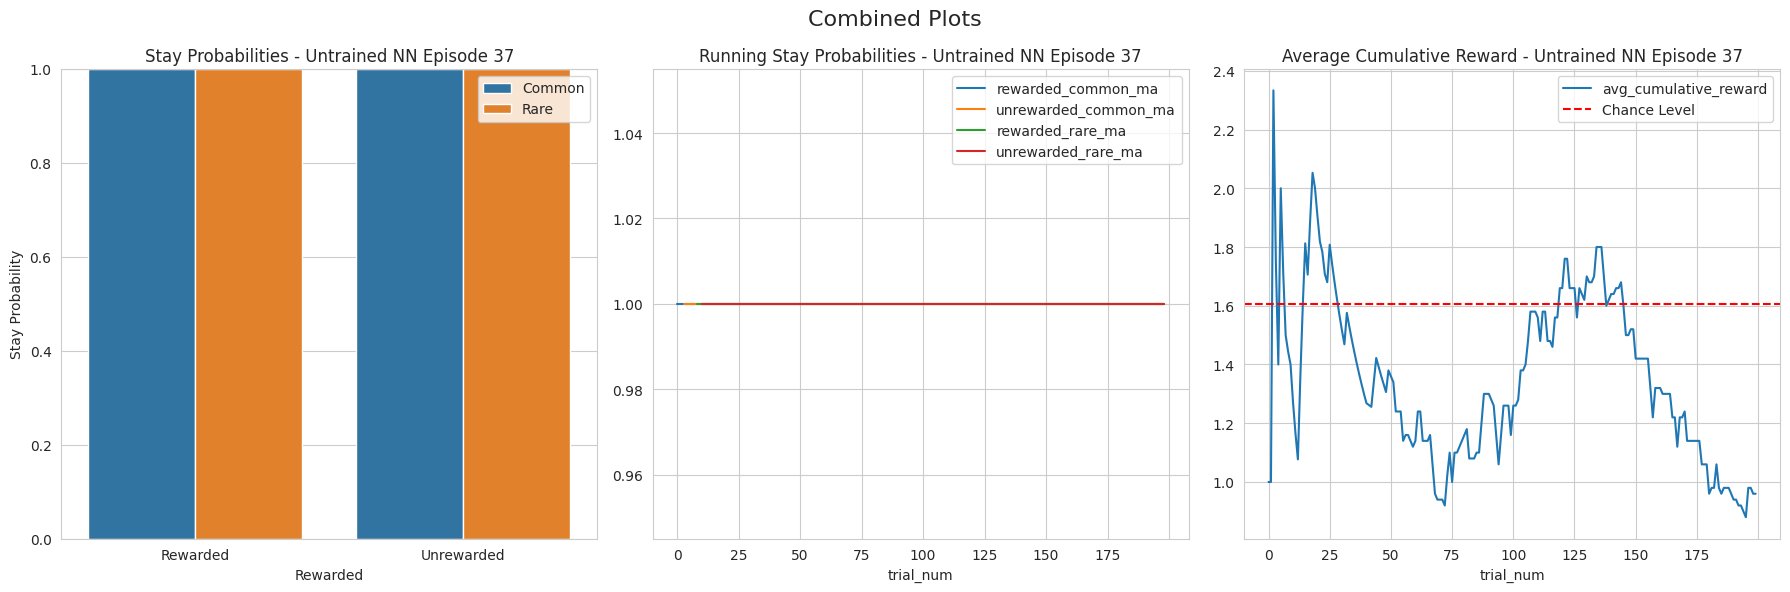

In [ ]:
episode = 37 # Change this to see other episodes #
data = df_untrained[df_untrained['episode'] == episode]
typeOfNN='Untrained NN'
plot_combined_single(data, label=f'{typeOfNN} Episode {episode}', title='Combined Plots')

In [ ]:
# Import necessary libraries
import gymnasium as gym
from enum import Enum
import random
import numpy as np
from scipy.stats import norm

from os import truncate

# Enum defining possible actions the agent can take in the environment: LEFT or RIGHT
class AgentAction(Enum):
    LEFT = 0
    RIGHT = 1

    # Method to get the integer value of the action (0 or 1)
    def get_value(self):
        return self.value

# Enum defining various grid tiles in the environment (e.g., agent, green spaceship, blue spaceship, aliens)
class GridTile(Enum):
    Agent = 0
    Green_Spaceship = 1
    Blue_Spaceship = 2
    R_1_Alien = 3
    R_2_Alien = 4
    P_1_Alien = 5
    P_2_Alien = 6

    # Method to return the first 3 letters of the tile name for printing
    def __str__(self):
        return self.name[:3]

    # Method to get the integer value associated with the grid tile
    def get_value(self):
        return self.value

# Class representing the Two-Step Task environment
class Two_Step_Task:

    # Initialize the environment with grid size and frame rate per second (fps)
    def __init__(self, grid_rows=3, grid_cols=3, fps=1):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.reset()

    # Reset the environment to its initial state
    def reset(self, seed=None):
        random.seed(seed)  # Set the seed for reproducibility
        self.state = [1, 0, 0]  # Initial state (one-hot encoding)
        self.assign_stimulus()  # Assign stimulus for the left and right actions

        # Positions for rendering the agent and the stimuli
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]

        self.generate_rewards()  # Generate reward probabilities for each action
        self.trial_num = 1  # Initialize trial number
        self.common = False  # Flag for common stimulus
        self.winning_prob_matrix = []  # Reward probabilities matrix
        self.stake = 1  # Initial stake
        self.score = 0  # Initial score

    # Reset for a new trial
    def reset_trial(self):
        self.state = [1, 0, 0]  # Reset state to initial state
        self.assign_stimulus()  # Re-assign stimuli
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]
        self.common = False  # Reset common flag

    # Generate reward probabilities for each trial based on Gaussian noise
    def generate_rewards(self):
        self.bounds = [0, 1]  # Set reward bounds
        self.sd = 0.025  # Standard deviation for noise
        self.choices = 2  # Number of possible choices (left or right)
        self.nrtrials = 200  # Number of trials

        # Ensure the bounds are sorted
        self.bounds = np.sort(self.bounds)

        # Initialize rewards matrix
        self.rewards = np.zeros((self.nrtrials, 2, self.choices))

        # Randomly generate reward probabilities for the first trial
        if np.random.rand() < 0.5:
            if np.random.rand() < 0.5:
                x = np.array([0.6, 0.4])
            else:
                x = np.array([0.4, 0.6])
            if np.random.rand() < 0.5:
                x = np.array([x, [0.25, 0.75]])
            else:
                x = np.array([x, [0.75, 0.25]])
        else:
            if np.random.rand() < 0.5:
                x = np.array([0.4, 0.6])
            else:
                x = np.array([0.6, 0.4])
            if np.random.rand() < 0.5:
                x = np.array([[0.25, 0.75], x])
            else:
                x = np.array([[0.75, 0.25], x])

        # Set the reward for the first trial
        self.rewards[0, :, :] = x

        # Loop through each trial to update the rewards with Gaussian noise
        for t in range(1, self.nrtrials):
            for s in range(2):  # Two states
                for a in range(self.choices):  # Two actions (left or right)
                    # Update reward with noise and ensure it stays within bounds
                    self.rewards[t, s, a] = self.rewards[t-1, s, a] + norm.rvs(scale=self.sd)
                    self.rewards[t, s, a] = min(self.rewards[t, s, a], max(self.bounds[1] * 2 - self.rewards[t, s, a], self.bounds[0]))
                    self.rewards[t, s, a] = max(self.rewards[t, s, a], min(self.bounds[0] * 2 - self.rewards[t, s, a], self.bounds[1]))

        # Round rewards to 3 decimal places
        self.rewards = np.round(self.rewards, 3)
        return self.rewards

    # Reset the stake randomly (either 1 or 5)
    def reset_stake(self):
        p = random.random()
        if p <= 0.5:
            self.stake = 1
        else:
            self.stake = 5

    # Assign a stimulus (Green_Spaceship or Blue_Spaceship) to the agent's environment
    def assign_stimulus(self, stim_1=GridTile.Green_Spaceship, stim_2=GridTile.Blue_Spaceship):
        p = random.random()
        if p <= 0.5:
            self.left_stim = stim_1
            self.right_stim = stim_2
        else:
            self.left_stim = stim_2
            self.right_stim = stim_1
        self.state_part2 = [self.left_stim.get_value(), self.right_stim.get_value()]

    # Assign a planet based on the spaceship type (Green or Blue)
    def assign_planet(self, space_ship: GridTile):
        p = random.random()
        if space_ship == GridTile.Green_Spaceship:
            if p <= 0.7:
                self.state = [0, 1, 0]  # Red planet
                self.assign_stimulus(GridTile.R_1_Alien, GridTile.R_2_Alien)
                self.common = True
            else:
                self.state = [0, 0, 1]  # Purple planet
                self.assign_stimulus(GridTile.P_1_Alien, GridTile.P_2_Alien)
                self.common = False
        elif space_ship == GridTile.Blue_Spaceship:
            if p <= 0.7:
                self.state = [0, 0, 1]  # Purple planet
                self.assign_stimulus(GridTile.P_1_Alien, GridTile.P_2_Alien)
                self.common = True
            else:
                self.state = [0, 1, 0]  # Red planet
                self.assign_stimulus(GridTile.R_1_Alien, GridTile.R_2_Alien)
                self.common = False

    # Perform the action (left or right) and return whether the trial is finished
    def perform_action(self, agent_action: AgentAction) -> bool:
        done = False

        if self.state[0]:  # If it's stage 1
            if agent_action == AgentAction.LEFT:
                self.assign_planet(self.left_stim)
            if agent_action == AgentAction.RIGHT:
                self.assign_planet(self.right_stim)
        else:  # It's stage 2
            done = True
            reward_ind_state = self.state.index(1) - 1
            reward_ind_action = agent_action.get_value()
            self.reward_prob = self.rewards[self.trial_num - 1, reward_ind_state, reward_ind_action]
            self.winning_prob_matrix = self.rewards[self.trial_num - 1, :, :]
            if self.trial_num <= 199:
                self.trial_num += 1
            else:
                return done

        return done

    # Render the environment's current state
    def render(self):
        for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                if [r, c] == self.agent_pos:
                    print(GridTile.Agent, end=' ')
                elif [r, c] == self.left_stim_pos:
                    print(GridTile(self.left_stim), end=' ')
                elif [r, c] == self.right_stim_pos:
                    print(GridTile(self.right_stim), end=' ')
                else:
                    print(' ', end=' ')
            print()
        print()

# Custom environment definition for Gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.utils.env_checker import check_env
import numpy as np

# Implement a custom Gym environment, inheriting from gym.Env
class TwoStepTaskEnv(gym.Env):
    metadata = {"render_modes": ["human"], 'render_fps': 1}  # Required metadata

    # Initialize the environment
    def __init__(self, grid_rows=3, grid_cols=3, render_mode=None):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.render_mode = render_mode

        # Initialize the Two_Step_Task instance
        self.task_agent = Two_Step_Task(grid_rows=grid_rows, grid_cols=grid_cols, fps=self.metadata['render_fps'])

        # Define action and observation space
        self.action_space = spaces.Discrete(len(AgentAction))
        self.observation_space = spaces.Box(
            low=0,
            high=600,
            shape=(7,),
            dtype=np.int64
        )

    # Reset the environment and return the initial observation
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure the environment can be reproduced
        self.task_agent.reset(seed=seed)
        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((7,))
        info = {}  # Optional additional information

        # Render if necessary
        if self.render_mode == 'human':
            self.render()

        return obs, info

    # Render the environment's current state
    def render(self):
        self.task_agent.render()

    # Step function to perform an action and return the new state, reward, etc.
    def step(self, action):
        end_of_trial = self.task_agent.perform_action(AgentAction(action))

        # Calculate reward and termination status
        reward = 0
        terminated = False
        if end_of_trial:
            reward = int(bool(np.random.rand() < self.task_agent.reward_prob)) * self.task_agent.stake
            self.task_agent.score += reward
            self.task_agent.reset_stake()
            self.task_agent.reset_trial()

        if self.task_agent.trial_num >= 200:
            terminated = True

        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((7,))

        # Info dictionary with additional trial info
        info = {'number of trials': self.task_agent.trial_num,
                'common': self.task_agent.common,
                'winning_matrix': self.task_agent.winning_prob_matrix,
                'stake': self.task_agent.stake}

        if self.render_mode == 'human':
            print(AgentAction(action))
            self.render()

        return obs, reward, terminated, False, info

# Register the environment with Gym so it can be used in gym.make()
register(
      id='two-step-task-original-v0',  # ID for the environment
      entry_point=TwoStepTaskEnv,  # The class to be used for the environment
)
